<a href="https://colab.research.google.com/github/kevc528/MovieDatasetAnalysis/blob/master/KevinChen_MoviesNotebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CIS545 Final Project: Analyzing Movie Data
#### Kevin Chen

In [1]:
# Need a folder in google drive called "Kaggle", containing "kaggle.json", a 
# file that is created after obtaining Kaggle API access
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/Kaggle"

%cd /content/gdrive/My Drive/Kaggle

!kaggle datasets download -d rounakbanik/the-movies-dataset

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive
/content/gdrive/My Drive/Kaggle
100% 227M/228M [00:01<00:00, 147MB/s]
100% 228M/228M [00:01<00:00, 124MB/s]


In [2]:
!unzip \*.zip  && rm *.zip

Archive:  the-movies-dataset.zip
replace credits.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: credits.csv             
  inflating: keywords.csv            
  inflating: links.csv               
  inflating: links_small.csv         
  inflating: movies_metadata.csv     
  inflating: ratings.csv             
  inflating: ratings_small.csv       


In [3]:
!pip install pandasql

  Created wheel for pandasql: filename=pandasql-0.7.3-cp36-none-any.whl size=26819 sha256=62fdcc673ca6cbd15545050c5197dc22d8e43a293821a9fec9f72ebd93781a2e
  Stored in directory: /root/.cache/pip/wheels/53/6c/18/b87a2e5fa8a82e9c026311de56210b8d1c01846e18a9607fc9
Successfully built pandasql


In [4]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import pandasql as ps
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


#### Let's first start by looking at some information about movies. First let's import the data. Note that the movies are filtered to have more than 20 votes because then a single vote won't have as much weight and there is a more general consesus about the movie. Mainly let's look at which movies are the highest rated and which are the lowest rated. We can do this with a few simple SQL queries using pandasql.

In [300]:
import json

movies_df = pd.read_csv('movies_metadata.csv', low_memory=False, index_col= 'id')

# converting to the correct types
movies_df = movies_df[movies_df.budget.apply(lambda x: x.isnumeric())]
movies_df['vote_count'] = pd.to_numeric(movies_df['vote_count'])
movies_df['budget'] = pd.to_numeric(movies_df['budget'])

movies_df = movies_df[(movies_df['budget'] > 0) & (movies_df['vote_count'] > 20)]

movies_df['adult'] = movies_df['adult'].astype('bool')
movies_df['release_date'] = pd.to_datetime(movies_df['release_date'], errors='coerce')
movies_df['revenue'] = pd.to_numeric(movies_df['revenue'])
movies_df['popularity'] = pd.to_numeric(movies_df['popularity'])
movies_df['runtime'] = pd.to_numeric(movies_df['runtime'])
movies_df['vote_average'] = pd.to_numeric(movies_df['vote_average'])

movies_df = movies_df.replace({'\'': '"'}, regex=True)

movies_df.head()

,adult,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
id,,,,,,,,,,,,,,,,,,,,,,,
862,True,"{""id"": 10194, ""name"": ""Toy Story Collection"", ...",30000000,"[{""id"": 16, ""name"": ""Animation""}, {""id"": 35, ""...",http://toystory.disney.com/toy-story,tt0114709,en,Toy Story,"Led by Woody, Andy""s toys live happily in his ...",21.946943,/rhIRbceoE9lR4veEXuwCC2wARtG.jpg,"[{""name"": ""Pixar Animation Studios"", ""id"": 3}]","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",1995-10-30,373554033.0,81.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,NaN,Toy Story,False,7.7,5415.0
8844,True,NaN,65000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",NaN,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,17.015539,/vzmL6fP7aPKNKPRTFnZmiUfciyV.jpg,"[{""name"": ""TriStar Pictures"", ""id"": 559}, {""na...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",1995-12-15,262797249.0,104.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
31357,True,NaN,16000000,"[{""id"": 35, ""name"": ""Comedy""}, {""id"": 18, ""nam...",NaN,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",3.859495,/16XOMpEaLWkrcPqSQqhTmeJuqQl.jpg,"[{""name"": ""Twentieth Century Fox Film Corporat...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",1995-12-22,81452156.0,127.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
949,True,NaN,60000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",NaN,tt0113277,en,Heat,"Obsessive master thief, Neil McCauley leads a ...",17.924927,/zMyfPUelumio3tiDKPffaUpsQTD.jpg,"[{""name"": ""Regency Enterprises"", ""id"": 508}, {...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",1995-12-15,187436818.0,170.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,A Los Angeles Crime Saga,Heat,False,7.7,1886.0
11860,True,NaN,58000000,"[{""id"": 35, ""name"": ""Comedy""}, {""id"": 10749, ""...",NaN,tt0114319,en,Sabrina,An ugly duckling having undergone a remarkable...,6.677277,/jQh15y5YB7bWz1NtffNZmRw0s9D.jpg,"[{""name"": ""Paramount Pictures"", ""id"": 4}, {""na...","[{""iso_3166_1"": ""DE"", ""name"": ""Germany""}, {""is...",1995-12-15,0.0,127.0,"[{""iso_639_1"": ""fr"", ""name"": ""Français""}, {""is...",Released,You are cordially invited to the most surprisi...,Sabrina,False,6.2,141.0


In [260]:
credits_df = movies_df = pd.read_csv('credits.csv', low_memory=False, index_col = 'id')
credits_df = credits_df.replace({'\'': '"'}, regex=True)
credits_df.head()

,cast,crew
id,,
862,"[{""cast_id"": 14, ""character"": ""Woody (voice)"",...","[{""credit_id"": ""52fe4284c3a36847f8024f49"", ""de..."
8844,"[{""cast_id"": 1, ""character"": ""Alan Parrish"", ""...","[{""credit_id"": ""52fe44bfc3a36847f80a7cd1"", ""de..."
15602,"[{""cast_id"": 2, ""character"": ""Max Goldman"", ""c...","[{""credit_id"": ""52fe466a9251416c75077a89"", ""de..."
31357,"[{""cast_id"": 1, ""character"": ""Savannah ""Vannah...","[{""credit_id"": ""52fe44779251416c91011acb"", ""de..."
11862,"[{""cast_id"": 1, ""character"": ""George Banks"", ""...","[{""credit_id"": ""52fe44959251416c75039ed7"", ""de..."


In [231]:
sqldf = lambda x : ps.sqldf(x, globals())

q = '''
    SELECT title, vote_average, vote_count
    FROM movies_df
    ORDER BY vote_average DESC
    LIMIT 40
    '''

top_rated_df = sqldf(q)
top_rated_df

,title,vote_average,vote_count
0,Dilwale Dulhania Le Jayenge,9.1,661.0
1,Stop Making Sense,8.7,47.0
2,Human,8.6,98.0
3,The Shawshank Redemption,8.5,8358.0
4,The Godfather,8.5,6024.0
5,Parched,8.5,23.0
6,Pulp Fiction,8.3,8670.0
7,Schindler's List,8.3,4436.0
8,One Flew Over the Cuckoo's Nest,8.3,3001.0
9,Psycho,8.3,2405.0


In [232]:
q = '''
    SELECT title, vote_average, vote_count
    FROM movies_df
    ORDER BY vote_average ASC
    LIMIT 40
    '''

low_rated_df = sqldf(q)
low_rated_df

,title,vote_average,vote_count
0,Manos: The Hands of Fate,2.0,56.0
1,Foodfight!,2.3,28.0
2,2012 Doomsday,2.3,32.0
3,Pledge This!,2.7,34.0
4,House of the Dead,2.8,106.0
5,Quantum Apocalypse,2.8,25.0
6,Dragonball Evolution,2.9,475.0
7,Ace Ventura Jr: Pet Detective,2.9,41.0
8,500 MPH Storm,2.9,21.0
9,Battlefield Earth,3.0,259.0


#### We notice that vote average ratings range from 2.0 to 9.1. Now let's look into more information about all of these movies and try to learn more about the movie industry. First let's start by looking at what the average rating of all these movies are and then dive into the distribution of ratings!

In [233]:
movie_average = movies_df['vote_average'].mean()
movie_average

6.248124152478539

In [234]:
rounded_ratings_df = movies_df[['title', 'vote_average']]
rounded_ratings_df['vote_average'] = rounded_ratings_df['vote_average'].apply(
                                            lambda x: round(x, 0)
                                          )
rounded_ratings_df

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,title,vote_average
id,,
862,Toy Story,8.0
8844,Jumanji,7.0
31357,Waiting to Exhale,6.0
949,Heat,8.0
11860,Sabrina,6.0
...,...,...
395834,Wind River,7.0
407448,Detroit,7.0
24049,Sivaji: The Boss,7.0


In [235]:
q = '''
    SELECT vote_average, COUNT(*) AS count
    FROM rounded_ratings_df
    WHERE vote_average IS NOT NULL
    GROUP BY vote_average
    '''

grouped_ratings_df = sqldf(q)
grouped_ratings_df

,vote_average,count
0,2.0,3
1,3.0,26
2,4.0,237
3,5.0,939
4,6.0,2835
5,7.0,2067
6,8.0,527
7,9.0,3


Text(0, 0.5, 'Count')

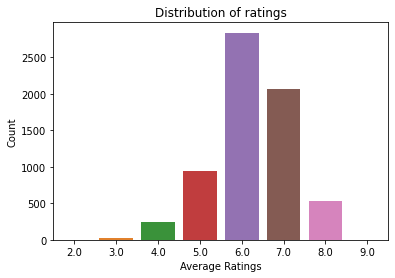

In [236]:
plt = sns.barplot(grouped_ratings_df['vote_average'], grouped_ratings_df['count'])
plt.set_title('Distribution of ratings')
plt.set_xlabel('Average Ratings')
plt.set_ylabel('Count')

#### Now that we know a bit of info on the ratings, let's explore more about the details of these movies. Let's start investigating common trends among movies and learn more about the movie industry! Throughout this process, we can also learn about some possible trends that make movies good.

In [237]:
import ast

df1 = (pd.concat({k: pd.DataFrame(json.loads(v)) for k, v in movies_df['genres'].items()})
         .reset_index(level=1, drop=True))

# new table useful because # of genres won't overscale anything else
movies_df_genres = movies_df.join(df1, rsuffix='_genre').reset_index(drop=True)
movies_df_genres.rename(columns={"name": "genre_name"}, inplace=True)
movies_df_genres.head()

,adult,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,id,genre_name
0,True,NaN,1350000,"[{""id"": 35, ""name"": ""Comedy""}, {""id"": 80, ""nam...",http://www.universalstudiosentertainment.com/l...,tt0120735,en,"Lock, Stock and Two Smoking Barrels",A card sharp and his unwillingly-enlisted frie...,4.60786,/qV7QaSf7f7yC2lc985zfyOJIAIN.jpg,"[{""name"": ""Handmade Films Ltd."", ""id"": 146}, {...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""}]",1998-03-05,3897569.0,105.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,A Disgrace to Criminals Everywhere.,"Lock, Stock and Two Smoking Barrels",False,7.5,1671.0,35.0,Comedy
1,True,NaN,1350000,"[{""id"": 35, ""name"": ""Comedy""}, {""id"": 80, ""nam...",http://www.universalstudiosentertainment.com/l...,tt0120735,en,"Lock, Stock and Two Smoking Barrels",A card sharp and his unwillingly-enlisted frie...,4.60786,/qV7QaSf7f7yC2lc985zfyOJIAIN.jpg,"[{""name"": ""Handmade Films Ltd."", ""id"": 146}, {...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""}]",1998-03-05,3897569.0,105.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,A Disgrace to Criminals Everywhere.,"Lock, Stock and Two Smoking Barrels",False,7.5,1671.0,80.0,Crime
2,True,"{""id"": 86224, ""name"": ""The Saint Collection"", ...",68000000,"[{""id"": 53, ""name"": ""Thriller""}, {""id"": 28, ""n...",NaN,tt0120053,en,The Saint,"Ivan Tretiak, Russian Mafia boss who wants to ...",10.97633,/uA24D8JCg21RDINMZ3vFaQYdIzW.jpg,"[{""name"": ""Paramount Pictures"", ""id"": 4}, {""na...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",1997-04-03,118063304.0,116.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Never reveal your name. Never turn your back. ...,The Saint,False,5.9,310.0,53.0,Thriller
3,True,"{""id"": 86224, ""name"": ""The Saint Collection"", ...",68000000,"[{""id"": 53, ""name"": ""Thriller""}, {""id"": 28, ""n...",NaN,tt0120053,en,The Saint,"Ivan Tretiak, Russian Mafia boss who wants to ...",10.97633,/uA24D8JCg21RDINMZ3vFaQYdIzW.jpg,"[{""name"": ""Paramount Pictures"", ""id"": 4}, {""na...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",1997-04-03,118063304.0,116.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Never reveal your name. Never turn your back. ...,The Saint,False,5.9,310.0,28.0,Action
4,True,"{""id"": 86224, ""name"": ""The Saint Collection"", ...",68000000,"[{""id"": 53, ""name"": ""Thriller""}, {""id"": 28, ""n...",NaN,tt0120053,en,The Saint,"Ivan Tretiak, Russian Mafia boss who wants to ...",10.97633,/uA24D8JCg21RDINMZ3vFaQYdIzW.jpg,"[{""name"": ""Paramount Pictures"", ""id"": 4}, {""na...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",1997-04-03,118063304.0,116.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Never reveal your name. Never turn your back. ...,The Saint,False,5.9,310.0,10749.0,Romance


In [0]:
import json

genres = {}

for genre in movies_df_genres['genre_name']:
  if genre in genres:
    genres[genre] += 1
  else:
    genres[genre] = 1

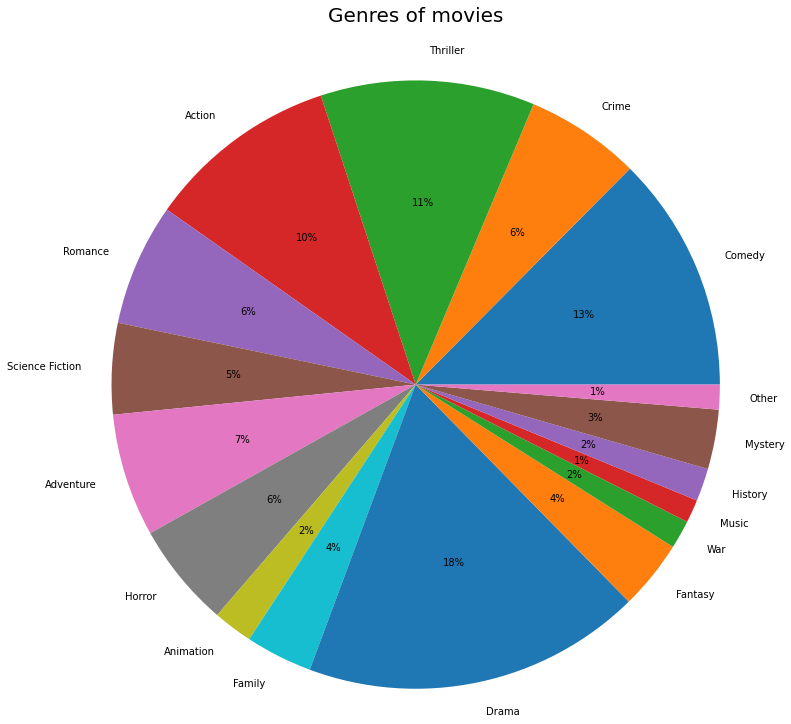

In [239]:
import matplotlib.pyplot as plt

genres['Other'] = 0
to_del = []

for g in genres:
  if g != 'Other':
    if genres[g] < 200:
      genres['Other'] += genres[g]
      to_del.append(g)

for d in to_del:
  del genres[d]

sizes = [genres[x] for x in genres]
labels=[x for x in genres]

try:
  fig1, ax1 = plt.subplots()
  fig1.set_size_inches(12, 12)
  patches, text = ax1.pie(sizes, labels=labels, autopct='%.0f%%')
except:
  pass

ax1.axis('equal')
ax1.set_title("Genres of movies", fontsize = 20)
ax1.title.set_position([.5, 1.05])
plt.show()

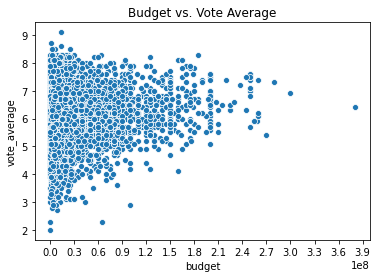

In [240]:
import matplotlib.ticker as ticker

ax = sns.scatterplot(movies_df['budget'], movies_df['vote_average'])
ax.xaxis.set_major_formatter(ax.get_xaxis().get_major_formatter())
ax.xaxis.set_major_locator(ticker.MultipleLocator(base=30000000))
ax.set_title('Budget vs. Vote Average')
ax.set_xlabel
plt.show()

Text(0.5, 1.0, 'Vote Average vs. Revenue')

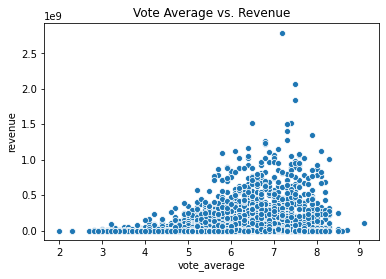

In [241]:
ax = sns.scatterplot(movies_df['vote_average'], movies_df['revenue'])
ax.set_title('Vote Average vs. Revenue')

Text(0, 0.5, 'Count')

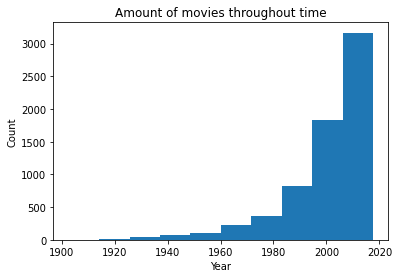

In [242]:
ax = plt.hist(movies_df['release_date'])
plt.title('Amount of movies throughout time')
plt.xlabel('Year')
plt.ylabel('Count')

#### Now let's start preparing the data for machine learning! First we will dive into creating clusters for movies and recommending based on this. To set up, we drop columns, merge any features we want and also create one-hot encodings for the id's that shouldn't be treated numerically. 

In [380]:
clustering_df = movies_df.copy(deep = True)

clustering_df['drama'] = clustering_df['genres'].apply(lambda x : 1 if 'Drama' in x else 0)
clustering_df['comedy'] = clustering_df['genres'].apply(lambda x : 1 if 'Comedy' in x else 0)
clustering_df['thriller'] = clustering_df['genres'].apply(lambda x : 1 if 'Thriller' in x else 0)
clustering_df['action'] = clustering_df['genres'].apply(lambda x : 1 if 'Action' in x else 0)
clustering_df['adventure'] = clustering_df['genres'].apply(lambda x : 1 if 'Adventure' in x else 0)

def company(x):
    try:
        return json.loads(x)[0]['id']
    except:
        return -1

clustering_df['production_companies'] = clustering_df['production_companies'].apply(company)

clustering_df = clustering_df.drop(columns=['homepage', 'genres', 'imdb_id', 'original_language', 'original_title', 
                            'overview', 'poster_path', 'status', 'tagline', 'title', 'video', 'belongs_to_collection',
                            'production_countries', 'spoken_languages','release_date'
                            ])
clustering_df = pd.get_dummies(clustering_df, prefix = ['production_companies'], columns=['production_companies'])
clustering_df.head()

,adult,budget,popularity,revenue,runtime,vote_average,vote_count,drama,comedy,thriller,action,adventure,production_companies_-1,production_companies_1,production_companies_2,production_companies_3,production_companies_4,production_companies_5,production_companies_6,production_companies_7,production_companies_8,production_companies_9,production_companies_11,production_companies_12,production_companies_13,production_companies_14,production_companies_15,production_companies_16,production_companies_17,production_companies_18,production_companies_23,production_companies_24,production_companies_25,production_companies_27,production_companies_28,production_companies_29,production_companies_32,production_companies_33,production_companies_34,production_companies_35,...,production_companies_68257,production_companies_68384,production_companies_68620,production_companies_68860,production_companies_69112,production_companies_69791,production_companies_72023,production_companies_72184,production_companies_72926,production_companies_73436,production_companies_73571,production_companies_74116,production_companies_74361,production_companies_74807,production_companies_74910,production_companies_75277,production_companies_76460,production_companies_76634,production_companies_77019,production_companies_77471,production_companies_77970,production_companies_78370,production_companies_78688,production_companies_79986,production_companies_80514,production_companies_81142,production_companies_81175,production_companies_81254,production_companies_84797,production_companies_84803,production_companies_85028,production_companies_85627,production_companies_85869,production_companies_86256,production_companies_87426,production_companies_89312,production_companies_91244,production_companies_91689,production_companies_93065,production_companies_93224
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
862,True,30000000,21.946943,373554033.0,81.0,7.7,5415.0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8844,True,65000000,17.015539,262797249.0,104.0,6.9,2413.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
31357,True,16000000,3.859495,81452156.0,127.0,6.1,34.0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
949,True,60000000,17.924927,187436818.0,170.0,7.7,1886.0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
11860,True,58000000,6.677277,0.0,127.0,6.2,141.0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [0]:
q = '''
SELECT clustering_df.*, credits_df.crew
FROM clustering_df, credits_df
WHERE clustering_df.id = credits_df.id
'''

clustering_df = sqldf(q)

In [0]:
def director(x):
  x = x.split('},')
  for chunk in x:
    if 'Director' in chunk:
      group = chunk.split(',')
      for g in group:
        if '"id"' in g:
          index = g.find('id: ')
          return(g[index+8:])

clustering_df['director'] = clustering_df['crew'].apply(director)

In [383]:
clustering_df = clustering_df.drop(columns=['crew'])
clustering_df = pd.get_dummies(clustering_df, prefix = ['director'], columns=['director'])
clustering_df.head()

,id,adult,budget,popularity,revenue,runtime,vote_average,vote_count,drama,comedy,thriller,action,adventure,production_companies_-1,production_companies_1,production_companies_2,production_companies_3,production_companies_4,production_companies_5,production_companies_6,production_companies_7,production_companies_8,production_companies_9,production_companies_11,production_companies_12,production_companies_13,production_companies_14,production_companies_15,production_companies_16,production_companies_17,production_companies_18,production_companies_23,production_companies_24,production_companies_25,production_companies_27,production_companies_28,production_companies_29,production_companies_32,production_companies_33,production_companies_34,...,director_96691,director_967417,director_967767,director_967792,director_96813,director_96854,director_970129,director_97026,director_97131,director_97296,director_974,director_97555,director_97618,director_97710,director_97755,director_9789,director_97966,director_98132,director_9819,director_9820,director_9822,director_983909,director_98534,director_9855,director_98631,director_9867,director_9868,director_98750,director_9894,director_989512,director_9915,director_991868,director_99313,director_995407,director_995462,director_9965,director_997,director_998507,director_99916,director_999760
0,862,1,30000000,21.946943,373554033.0,81.0,7.7,5415.0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,8844,1,65000000,17.015539,262797249.0,104.0,6.9,2413.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,31357,1,16000000,3.859495,81452156.0,127.0,6.1,34.0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,949,1,60000000,17.924927,187436818.0,170.0,7.7,1886.0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,11860,1,58000000,6.677277,0.0,127.0,6.2,141.0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


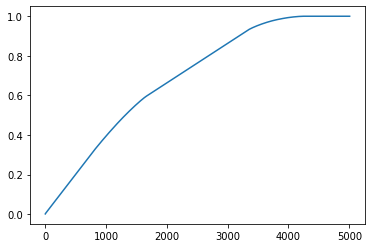

In [384]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

clustering_df = StandardScaler().fit_transform(clustering_df.dropna())

pca = PCA(n_components= 5007)
pca.fit(clustering_df)
pc_vs_variance = np.cumsum(pca.explained_variance_ratio_)
plt.plot(pc_vs_variance)
plt.show()

In [0]:
pca = PCA(n_components= 3300)
pca.fit(clustering_df)
clustering_df = pca.fit_transform(clustering_df)